# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.optimize import minimize

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [11]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [12]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,3921.359348,0.9999,-131.886217,1736.41,1604.523783
OMUSDT,526.319895,1681.883242,0.4289,0.000000,1155.56,1155.560000
BTCUSDT,601.021649,866.401084,0.2209,3.537078,265.38,268.917078
JASMYUSDT,387.458505,549.071346,0.1400,0.000000,161.61,161.610000
SOLUSDT,281.200518,390.925346,0.0997,0.000000,109.72,109.720000
ETHUSDT,250.747339,260.149292,0.0663,0.000000,9.40,9.400000
TRXUSDT,76.868953,128.433757,0.0328,-10.723889,51.56,40.836111
BBUSDT,60.176053,43.316978,0.0110,-39.733101,-16.86,-56.593101
BNBUSDT,1.142121,1.178297,0.0003,-10.606040,0.04,-10.566040
PEPEUSDT,0.000004,0.000006,0.0000,-38.521986,0.00,-38.521986


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [19]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [20]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [21]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

In [22]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24     23.503339
2024-09-25     -7.470131
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2024-12-04    -76.382206
2024-12-05    261.133085
2024-12-06     -9.697423
2024-12-07    -17.431069
2024-12-08    111.313093
Name: Total, Length: 77, dtype: float64

In [23]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [24]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [25]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [26]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [27]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [28]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [29]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

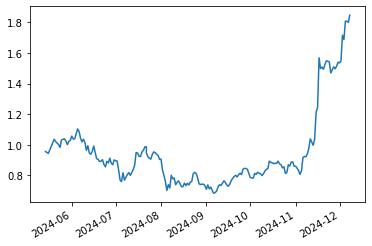

In [30]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [31]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [32]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [33]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT', 'BTCUSDT',
       'CRVUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'IOTAUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'OMUSDT', 'OPUSDT', 'PEPEUSDT',
       'QNTUSDT', 'RAYUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT',
       'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT',
       'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT',
       'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [34]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [35]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3984
BNBUSDT,0.1682
PEPEUSDT,0.1559
SUIUSDT,0.0699
TRXUSDT,0.0695
XLMUSDT,0.0527
XRPUSDT,0.0460
JASMYUSDT,0.0394
BONKUSDT,0.0000
RUNEUSDT,0.0000


In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.383419
BTCUSDT,0.300000
PEPEUSDT,0.121109
TRXUSDT,0.059177
SUIUSDT,0.048766
XLMUSDT,0.038082
JASMYUSDT,0.030735
BNBUSDT,0.018712


In [37]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [38]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
OMUSDT,0.365877
BTCUSDT,0.339449
TRXUSDT,0.204460
PEPEUSDT,0.090214


## Real Portfolio vs Optimal

In [39]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1681.883242,0.428903,0.365877,0.063026
BTCUSDT,866.401084,0.220944,0.339449,-0.118505
JASMYUSDT,549.071346,0.140021,0.000000,0.000000
SOLUSDT,390.925346,0.099691,0.000000,0.000000
ETHUSDT,260.149292,0.066342,0.000000,0.000000
TRXUSDT,128.433757,0.032752,0.204460,-0.171708
BBUSDT,43.316978,0.011046,0.000000,0.000000
BNBUSDT,1.178297,0.000300,0.000000,0.000000
PEPEUSDT,0.000006,0.000000,0.090214,-0.090214


In [40]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1681.883242,0.428903,0.383419,0.045484
BTCUSDT,866.401084,0.220944,0.300000,-0.079056
JASMYUSDT,549.071346,0.140021,0.030735,0.109286
SOLUSDT,390.925346,0.099691,0.000000,0.000000
ETHUSDT,260.149292,0.066342,0.000000,0.000000
TRXUSDT,128.433757,0.032752,0.059177,-0.026425
BBUSDT,43.316978,0.011046,0.000000,0.000000
BNBUSDT,1.178297,0.000300,0.018712,-0.018412
PEPEUSDT,0.000006,0.000000,0.121109,-0.121109
SUIUSDT,0.000000,0.000000,0.048766,0.000000


# Risk Reward Analysis

In [41]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [42]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

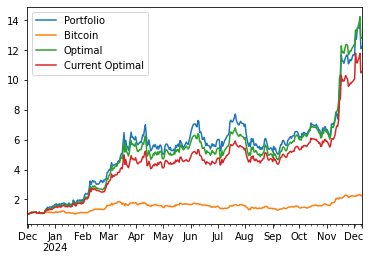

In [43]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [44]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

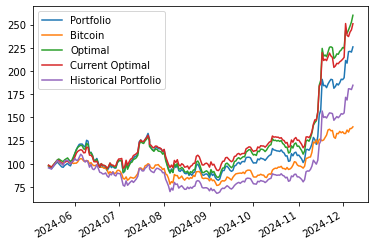

In [45]:
((1+current_perf).cumprod()*100).plot()

In [46]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-11-29,187.361562,134.971167,221.298313,209.922567,151.414174
2024-11-30,191.180417,133.506331,222.678209,211.072783,154.042164
2024-12-01,190.737188,134.578273,225.340801,212.745345,153.524639
2024-12-02,192.763205,132.703379,224.680508,214.747495,154.867822
2024-12-03,211.393426,132.715937,243.724632,251.183737,171.684779
2024-12-04,208.518312,136.453406,240.758998,238.493075,168.792541
2024-12-05,220.897120,134.162033,244.289240,237.161243,180.882889
2024-12-06,221.206994,137.975577,248.340261,241.906956,180.754476
2024-12-07,220.413967,138.101611,252.909509,244.447528,180.041463
2024-12-08,226.011384,139.857753,260.104887,250.997296,184.701345


## Volatilities

In [47]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.661934
 dtype: float64,
 0.662785796562892)

In [48]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.6451
 dtype: float64,
 0.6450999162260361)

In [49]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.709710
Bitcoin            0.435021
Optimal            0.662786
Current Optimal    0.622401
dtype: float64

In [50]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.45681249172252536

## Risk Contribution

In [51]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.029275,0.018712,0.002307,0.006373,0.000184,0.006189
BTCUSDT,0.376083,0.300000,0.032498,0.130831,0.038772,0.092060
JASMYUSDT,0.079775,0.030735,0.005312,0.021622,0.002709,0.018913
OMUSDT,18.303825,0.383419,0.898247,0.653292,0.550443,0.102849
PEPEUSDT,0.800690,0.121109,0.044308,0.127499,0.053678,0.073820
SUIUSDT,0.110964,0.048766,0.007678,0.028964,0.004921,0.024043
TRXUSDT,0.052793,0.059177,0.005382,0.016586,0.003825,0.012761
XLMUSDT,0.050714,0.038082,0.004268,0.014834,0.001981,0.012852


In [52]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.843655,0.365877,0.556137,0.606341,0.478246,0.128095
BTCUSDT,0.152570,0.339449,0.226228,0.151946,0.061002,0.090943
TRXUSDT,0.123478,0.204460,0.150784,0.154223,0.102652,0.051571
PEPEUSDT,0.055179,0.090214,0.066851,0.087490,0.030491,0.057000


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.991512,0.43,0.646193,0.638691,0.509446,0.129244
BTCUSDT,0.098882,0.22,0.144958,0.089418,0.019762,0.069656
JASMYUSDT,0.063947,0.14,0.092711,0.144967,0.055602,0.089365
SOLUSDT,0.024423,0.10,0.056560,0.071058,0.009983,0.061075
ETHUSDT,0.008699,0.07,0.035775,0.033357,0.003530,0.029827
TRXUSDT,0.018118,0.03,0.021873,0.011872,0.001704,0.010168
BBUSDT,-0.005755,0.01,0.001930,0.010637,0.000391,0.010245


# Value At Risk

## Historical

### Optimal Weights

In [54]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05259862778096572, -0.07787618481689527)

### Current Weights

In [55]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.048151061812145776, -0.07441724519539683)

In [56]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [57]:
var=historical_var.iloc[row]
var

OMUSDT      -0.016731
BTCUSDT     -0.011273
JASMYUSDT   -0.011370
SOLUSDT     -0.007623
ETHUSDT      0.001101
TRXUSDT     -0.001870
BBUSDT      -0.000124
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.047891
Name: 2024-11-25 00:00:00, dtype: float64

In [58]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.040710
BTCUSDT     -0.007590
JASMYUSDT   -0.012470
SOLUSDT     -0.006799
ETHUSDT     -0.002833
TRXUSDT     -0.000930
BBUSDT      -0.000875
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.072207
dtype: float64

## Parametric

### Optimal Weights

In [59]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06867523897712363, -0.08802266871669347)

### Current Weights

In [60]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06684269810954163, -0.08567385799394223)

## Multivariate

### Optimal Weights

In [61]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06009151381700803, -0.07788613130796394)

### Current Weights

In [62]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06136999683505056, -0.07803921720465914)

In [63]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.037066
BTCUSDT     -0.005965
JASMYUSDT   -0.009688
SOLUSDT     -0.005348
ETHUSDT     -0.002352
TRXUSDT     -0.000809
BBUSDT      -0.000827
Portfolio   -0.062054
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [64]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06151998608280881, -0.07870233710268928)

### Current Weights

In [65]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.062358662296469754, -0.08076793668789028)

In [66]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.041647
BTCUSDT     -0.005154
JASMYUSDT   -0.008313
SOLUSDT     -0.004239
ETHUSDT     -0.001733
TRXUSDT     -0.000544
BBUSDT      -0.000593
Portfolio   -0.062223
dtype: float64

## Student Copula

### Optimal Weights

In [67]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.061461069821795694, -0.07884779820109764)

### Current Weights

In [68]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06254746473273237, -0.07998435397350344)

In [69]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.039216
BTCUSDT     -0.005715
JASMYUSDT   -0.010091
SOLUSDT     -0.004694
ETHUSDT     -0.002380
TRXUSDT     -0.000612
BBUSDT      -0.000668
Portfolio   -0.063375
dtype: float64

## Gumbel Copula

### Optimal Weights

In [70]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11510792148639314, -0.16362285177362626)

### Current Weights

In [71]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10826489185476372, -0.15091689709796785)

In [72]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.092882
BTCUSDT     -0.003814
JASMYUSDT   -0.009355
SOLUSDT     -0.000294
ETHUSDT     -0.000983
TRXUSDT     -0.000328
BBUSDT      -0.000198
Portfolio   -0.107855
dtype: float64

## Monte Carlo

### Optimal

In [73]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [74]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07150000872932472, -0.08747302252587227)

### Current Weights

In [75]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06913135541116106, -0.08556860105988143)

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.042594
BTCUSDT     -0.006632
JASMYUSDT   -0.010455
SOLUSDT     -0.004893
ETHUSDT     -0.002350
TRXUSDT     -0.000808
BBUSDT      -0.000763
Portfolio   -0.068496
dtype: float64

## VaR Violation

In [77]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.056769,-0.095033,-0.078076,-0.026827
2024-01-15,-0.056769,-0.095034,-0.079116,0.016564
2024-01-16,-0.056769,-0.094938,-0.077084,0.045973
2024-01-17,-0.056769,-0.096717,-0.084381,-0.029112
2024-01-18,-0.056769,-0.099323,-0.087686,-0.039122
...,...,...,...,...
2024-12-06,-0.047656,-0.118569,-0.096810,0.016583
2024-12-07,-0.047656,-0.118398,-0.095334,0.018399
2024-12-08,-0.047656,-0.117406,-0.090326,0.028450
2024-12-09,-0.088030,-0.129513,-0.104753,-0.102806


In [78]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.034152,-0.084996,-0.083944,-0.017632
2024-05-29,-0.034152,-0.082329,-0.075296,-0.008918
2024-05-30,-0.034152,-0.072422,-0.069341,0.039622
2024-05-31,-0.034152,-0.073307,-0.065146,0.038617
2024-06-01,-0.034152,-0.076621,-0.068805,0.052272
...,...,...,...,...
2024-12-06,-0.043090,-0.075336,-0.062919,0.001403
2024-12-07,-0.043090,-0.075887,-0.063977,-0.003585
2024-12-08,-0.043090,-0.076390,-0.066103,0.025395
2024-12-09,-0.113315,-0.111785,-0.113590,-0.123966


<AxesSubplot:>

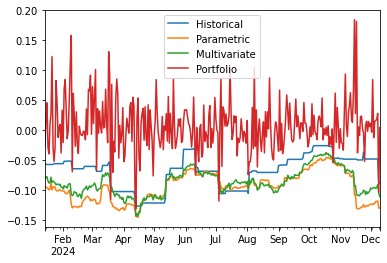

In [79]:
var_data.plot()

<AxesSubplot:>

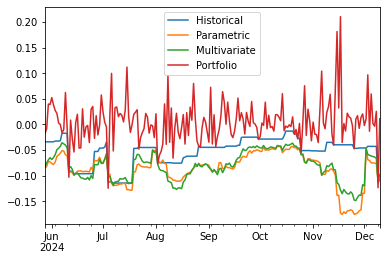

In [80]:
current_var_data.plot()

In [81]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.024096,0.009036,0.012048
Kupiec Stat,5.753015,17.513436,14.311922
P-value,0.01646,0.000029,0.000155


In [82]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.06599,0.020305,0.015228
Kupiec Stat,0.967744,4.671569,6.814562
P-value,0.325243,0.030666,0.009042


# Principal Component Analysis

## Historical PCA

In [83]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77211655, 0.074752  , 0.0594007 , 0.05277882, 0.04095192])

In [84]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014797
ADAUSDT     0.015328
ALGOUSDT    0.017306
APTUSDT     0.016025
ARBUSDT     0.016818
              ...   
WBTCUSDT    0.009336
WLDUSDT     0.022037
XLMUSDT     0.012339
XRPUSDT     0.010800
XTZUSDT     0.016167
Name: PC1, Length: 63, dtype: float64

<AxesSubplot:>

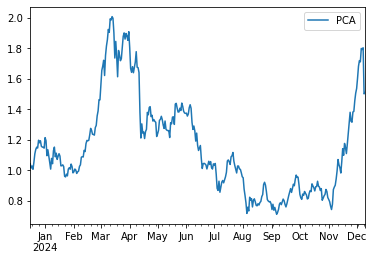

In [85]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<AxesSubplot:>

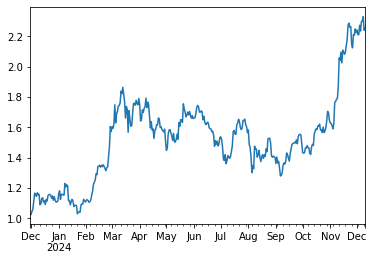

In [86]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [87]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
FLOWUSDT     0.412919
WBETHUSDT    0.425170
ETHUSDT      0.425181
EGLDUSDT     0.425654
               ...   
FLOKIUSDT    1.121040
BONKUSDT     1.125962
WLDUSDT      1.132248
PEPEUSDT     1.177726
OMUSDT       1.521725
Length: 64, dtype: float64

<AxesSubplot:>

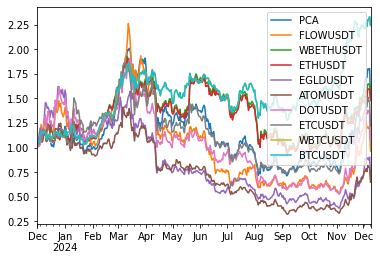

In [88]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

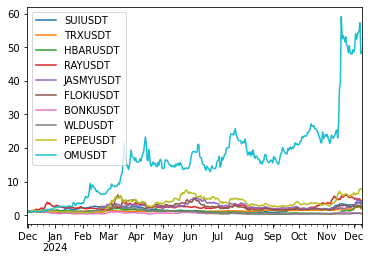

In [89]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [90]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.53164117, 0.1533025 , 0.13560969, 0.10245056, 0.07699608])

In [91]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.105600
BTCUSDT      0.061485
JASMYUSDT    0.165507
SOLUSDT      0.101743
ETHUSDT      0.082546
TRXUSDT      0.049314
BBUSDT       0.212372
BNBUSDT      0.067289
PEPEUSDT     0.154145
Name: PC1, dtype: float64

<AxesSubplot:>

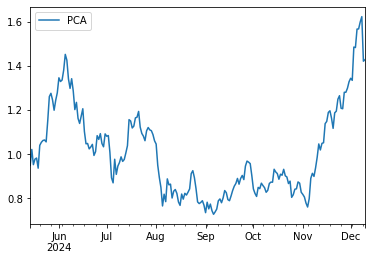

In [92]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

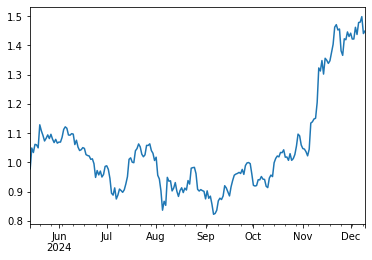

In [93]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [94]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
SOLUSDT      0.382473
ETHUSDT      0.403628
BNBUSDT      0.408145
BTCUSDT      0.421747
JASMYUSDT    0.640297
PEPEUSDT     0.703719
BBUSDT       0.714694
OMUSDT       0.859285
TRXUSDT      0.874394
dtype: float64

<AxesSubplot:>

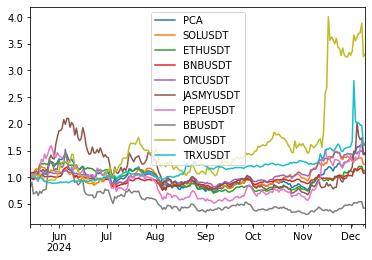

In [95]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [96]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.895855
BBUSDT       1.556793
JASMYUSDT    1.231501
SOLUSDT      1.145727
BTCUSDT      1.000000
ETHUSDT      0.955383
OMUSDT       0.893374
BNBUSDT      0.659881
TRXUSDT      0.263753
Name: BTCUSDT, dtype: float64

In [97]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.032909
ETHUSDT      1.741089
PEPEUSDT     1.485455
BNBUSDT      1.062853
SOLUSDT      1.052996
BTCUSDT      1.000000
OMUSDT       0.551577
TRXUSDT      0.043284
JASMYUSDT   -0.359163
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [98]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [99]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.697486
BBUSDT,0.441153
ETHUSDT,0.223171
JASMYUSDT,0.125072
OMUSDT,0.086607
TRXUSDT,0.016542
PEPEUSDT,-0.006941
BNBUSDT,-0.018971
SOLUSDT,-0.420048


### Regression to PCA

In [100]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.250239055357532

In [101]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.244951
BNBUSDT      1.099723
PCA          1.000000
ETHUSDT      0.954777
SOLUSDT      0.789895
JASMYUSDT    0.404361
PEPEUSDT     0.363568
BBUSDT       0.345866
OMUSDT       0.237539
TRXUSDT      0.180923
dtype: float64

In [102]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.755025
SOLUSDT      1.068842
PCA          1.000000
ETHUSDT      0.897647
BNBUSDT      0.773256
OMUSDT       0.717863
BBUSDT       0.638135
JASMYUSDT    0.157090
TRXUSDT      0.109337
PEPEUSDT     0.032071
dtype: float64

### Correlation Matrix

<AxesSubplot:>

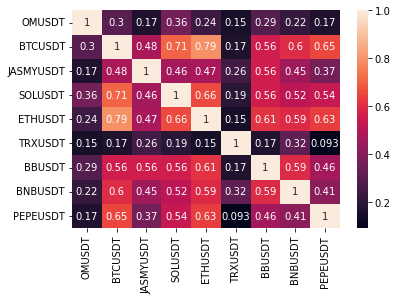

In [103]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<AxesSubplot:>

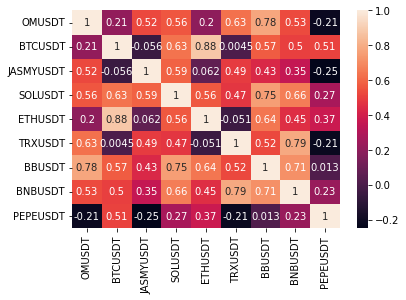

In [104]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [105]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.00000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.00000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.00000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.000000,0.112009,0.000000,0.340186,0.00000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.00000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.00000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.71256,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.00000,0.000000,0.130336


In [106]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-05-04,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-06-03,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-07-03,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.948311,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-08-02,0.614341,0.053671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.325820,0.0
2024-09-01,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.982006,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-10-01,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-10-31,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.664610,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0
2024-11-30,0.000000,0.044675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0347,0.182972,0.0
2024-12-10,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0


In [107]:
rolling_optimization.iloc[-1].sort_values(ascending=False)

PEPEUSDT     0.572516
HBARUSDT     0.153401
CRVUSDT      0.145859
JASMYUSDT    0.128224
SEIUSDT      0.000000
               ...   
GALAUSDT     0.000000
GRTUSDT      0.000000
ICPUSDT      0.000000
IMXUSDT      0.000000
XTZUSDT      0.000000
Name: 2024-12-10 00:00:00, Length: 63, dtype: float64

<AxesSubplot:>

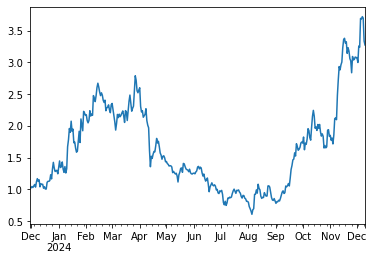

In [108]:
(1+returns_to_use['SUIUSDT']).cumprod().plot()